In [2]:
import torch
import numpy as np
from dynaconf import settings
import statistics
from metrics import get_pred_diffs, get_features_1c, mse, get_pred_diff

In [3]:
from data import AnomalyDatasetByConcat, EEGDataset, normalize, stackplot

In [7]:
class AvgModel(nn.Module):
    def __init__(self, n_predictions=10):
        super().__init__()
        self.n_predictions = n_predictions

    def forward(self, input_seq):
        input_seq = input_seq.squeeze()
        if len(input_seq.shape) == 1:
            # squeezed too much-- num channels and batch size of 1
            input_seq = input_seq.unsqueeze(0)
            
        avgs = torch.sum(input_seq[:, -self.n_predictions:], axis=1).unsqueeze(1)
        avgs = avgs.repeat((1, self.n_predictions))
        return avgs

In [8]:
avg_model = AvgModel()

In [9]:
import torch.nn as nn
class TorchNN(nn.Module):
    def __init__(self, input_length=250,n_predictions=10):
        super().__init__()
        self.fc1 = nn.Linear(input_length, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, n_predictions)

    def forward(self, input_seq):
        input_seq = input_seq.squeeze()
        if len(input_seq.shape) == 1:
            # squeezed too much-- num channels and batch size of 1
            input_seq = input_seq.unsqueeze(0)
        h = nn.functional.relu(self.fc1(input_seq))
        h = nn.functional.relu(self.fc2(h))
        h = nn.functional.relu(self.fc3(h))
        out = self.fc4(h)
        return out


In [20]:
nn_model = TorchNN()
# model_dict= torch.load("models/saved_models/basic_nn2.pt", map_location=torch.device("cpu"))
# cpu_model_dict = {}
# for key, val in model_dict.items():
#     cpu_model_dict[key] = val.cpu()
# nn_model.load_state_dict(cpu_model_dict)
model_dict= torch.load("models/saved_models/basic_nn1.pt")
nn_model.load_state_dict(model_dict)
nn_model.eval()
nn_model.cuda()

TorchNN(
  (fc1): Linear(in_features=250, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)

In [11]:
select_channels, length, n_predictions = settings.SELECT_CHANNELS, 260, 10
batch_size=16
use_cuda = torch.cuda.is_available()

In [12]:
train_dataset_csv = settings.TRAIN_DATASET_CSV
dev_dataset_csv = settings.DEV_DATASET_CSV

train_dataset = EEGDataset(train_dataset_csv, length, select_channels, max_num_examples=400, transform=normalize)
dev_dataset = EEGDataset(dev_dataset_csv, length, select_channels, max_num_examples=400, transform=normalize)

Found 2765 recordings
By set limit only using 400 recordings
Removing recordings of insufficient length...
Removed 0 of 400 recordings. There are now 400 recordings.
Found 345 recordings
By set limit only using 345 recordings
Removing recordings of insufficient length...
Removed 0 of 345 recordings. There are now 345 recordings.


In [13]:
first_recording_length = length - n_predictions
second_recording_length = n_predictions

train_dataset_anomaly = AnomalyDatasetByConcat(
    first_recording_length,
    second_recording_length,
    train_dataset_csv,
    length,
    select_channels,
    max_num_examples=400,
    transform=normalize
)

dev_dataset_anomaly = AnomalyDatasetByConcat(
    first_recording_length,
    second_recording_length,
    dev_dataset_csv,
    length,
    select_channels,
    max_num_examples=400,
    transform=normalize
)

Found 2765 recordings
By set limit only using 400 recordings
Removing recordings of insufficient length...
Removed 0 of 400 recordings. There are now 400 recordings.
Found 345 recordings
By set limit only using 345 recordings
Removing recordings of insufficient length...
Removed 0 of 345 recordings. There are now 345 recordings.


In [14]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

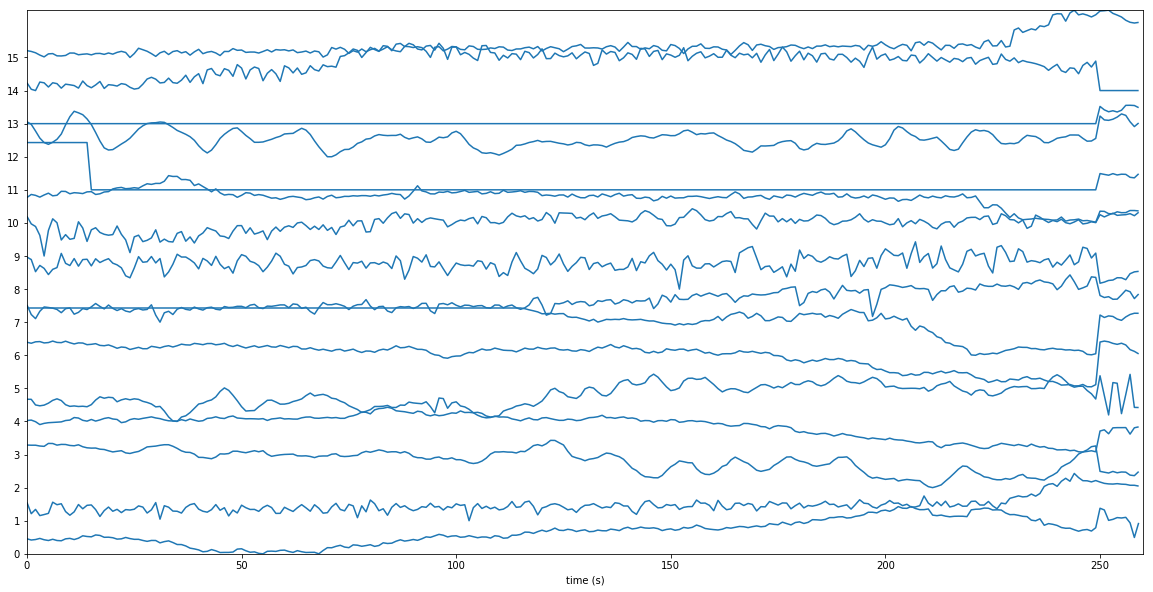

In [15]:
samples = np.asarray([train_dataset_anomaly[i].squeeze().numpy() for i in range(16)])
stackplot(samples)

In [16]:
def print_summary(diffs):
    print(f"mean {statistics.mean(diffs)}, median {statistics.median(diffs)}")

In [17]:
normal_diffs_avg = get_pred_diffs(avg_model, train_dataset, mse)

In [18]:
print_summary(normal_diffs_avg)

mean 39.49538806026801, median 38.509742736816406


In [21]:
normal_diffs_nn = get_pred_diffs(nn_model, train_dataset, mse)

In [22]:
print_summary(normal_diffs_nn)

mean 0.05770443297660677, median 0.024515570141375065


In [23]:
anomaly_diffs_avg = get_pred_diffs(avg_model, train_dataset_anomaly, mse)

In [24]:
print_summary(anomaly_diffs_avg)

mean 154.75356619771685, median 39.69678497314453


In [25]:
anomaly_diffs_nn = get_pred_diffs(nn_model, train_dataset_anomaly, mse)

In [26]:
print_summary(anomaly_diffs_nn)

mean 0.8549384426255711, median 0.2328980788588524


#### Simple decision tree

In [34]:
from sklearn.tree import DecisionTreeClassifier
from random import shuffle

In [45]:
features_avg = []
for example in train_dataset:
    diff = get_pred_diff(avg_model, example, mse)
    features_avg.append([0, diff])
for example in train_dataset_anomaly:
    diff = get_pred_diff(avg_model, example, mse)
    features_avg.append([1, diff])


In [44]:
features_nn = []
for example in train_dataset:
    diff = get_pred_diff(avg_model, example, mse)
    features_nn.append([0, diff])
for example in train_dataset_anomaly:
    diff = get_pred_diff(avg_model, example, mse)
    features_nn.append([1, diff])

In [46]:
shuffle(features_nn)
shuffle(features_avg)

In [47]:
train_data_nn = np.asarray(features_nn[:-20])
eval_data_nn = np.asarray(features_nn[-20:])
train_data_avg = np.asarray(features_avg[:-20])
eval_data_avg = np.asarray(features_avg[-20:])

#### With NN

In [68]:
clf_nn = DecisionTreeClassifier()

In [69]:
x = train_data_nn[:, 1:]
y = train_data_nn[:, :1].squeeze().astype('int')
clf_nn.fit(x, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [70]:
eval_x = train_data_nn[:, 1:]
eval_y = train_data_nn[:, :1].squeeze().astype('int')
clf_nn.score(eval_x, eval_y)

0.9961538461538462

#### With AVG

In [71]:
clf_avg = DecisionTreeClassifier()

In [72]:
x = train_data_avg[:, 1:]
y = train_data_avg[:, :1].squeeze().astype('int')
clf_avg.fit(x, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [73]:
eval_x = train_data_avg[:, 1:]
eval_y = train_data_avg[:, :1].squeeze().astype('int')
clf_avg.score(eval_x, eval_y)

0.9935897435897436

temple seizure (channels labeled)

.lbl (label files) those contain the timepoint, channels, type 

_aaREADME

- create anomaly set with 'real' data
- continue working on torch LSTM
- add violin plots for LSTM/NN
- compare classifier accuracy with and without mne features